In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create Masks

In [27]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from config import raw_data_dir, processed_data_dir

from rasterio.plot import show

%matplotlib inline

# Test dir
date = '2017-01-01'
images_dir ='../data/interim/images-merged/'

img_dir = img_dir = os.path.join(images_dir, date)

out_dir = os.path.join(processed_data_dir, 'data_v1', date)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)


res_groups = {
    '60': ['B01', 'B09', 'B10'],
    '20': ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'],
    '10': ['B02', 'B03', 'B04', 'B08', 'TCI']
}

# Dimensions to zero-pad images to
MAX_DIMS = {
    '10': (90, 90),
    '20': (50, 50),
    '60': (20, 20)
}

## Read Shapefile

In [28]:
train_fp = os.path.join(raw_data_dir,'train/train.shp')
train_df = gpd.read_file(train_fp)

# Drop NaNs
train_df = train_df.loc[~train_df.geometry.isna()]
train_df.reset_index(drop=True, inplace=True)

# Convert shapefile to coordinate system of raster
train_df = train_df.to_crs({'init': 'epsg:32734'})

train_df.head()

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,..."
1,2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,..."
2,3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,..."
3,4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,..."
4,7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,..."


## Read Raster

In [29]:
! ls $img_dir

B01.jp2 B03.jp2 B05.jp2 B07.jp2 B10.jp2 B12.jp2 TCI.jp2
B02.jp2 B04.jp2 B06.jp2 B09.jp2 B11.jp2 B8A.jp2


In [30]:
band = 'B04'
fp = os.path.join(img_dir, f'{band}.jp2')
raster = rasterio.open(fp)

### Approach

1. Create mask array for all farms on the entire raster
 - ie create a boolean mask array of the same shape of the raster which is 1 where farms are present in pixels.
2. Get window of desired shape containing farm shape and surrounding data
3. Read image data of window
4. Read mask data of window
5. Combine image and mask data into one array with multiple channels

In [31]:
import rasterio
from rasterio.mask import raster_geometry_mask

def get_mask_window(shape, raster, max_dims=None):
    
    # Get the boolean mask and window of shape
    try:
        bool_mask, transform, bb_window = raster_geometry_mask(raster, [shape], crop=True)
    except ValueError:
        return None
    
    if max_dims is  None:
        return bb_window
    else:
        # Turn mask into int array with 1 at farm pixels
        int_mask = np.bitwise_not(bool_mask).astype(int)

        # Get the shape of the bounding box window
        bb_shape = (bb_window.height, bb_window.width)


        # Get number of pixels to add to x and y dims
        pad_x = int(np.ceil((max_dims[1]-bb_shape[1])/2))
        pad_y = int(np.ceil((max_dims[0]-bb_shape[0])/2))

        # Get a window with padding around it and the desired shape in the center
        # Depending on the shape, this window can be a different size than max_dims
        window_ = rasterio.mask.geometry_window(raster, 
                                                      [shape], 
                                                      pad_x=pad_x, 
                                                      pad_y=pad_y, 
                                                      pixel_precision=2 # I found this fixes some rounding errors
                                                     )

        # To fix sizing issues, create a new window that starts at the same top left anchor, but of a fixed width and height
        window = rasterio.windows.Window(col_off=window_.col_off, row_off=window_.row_off, width=max_dims[1], height=max_dims[0])
    
        return window
    
    
def get_farm_data(masked_raster, raster, farm_shape, out_shape):
    
    bands = raster.count
    
    # The window defining where on the raster this shape is found
    mask_window = get_mask_window(farm_shape, raster, max_dims=None)
    
    if mask_window is None:
        return 0.
    
    # The same window, but padded to the desired dims
    mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

    # Crop out the image data around the shape 
    win_img = raster.read(window=mask_window_padded)[0]

    # Crop out the boolean mask of all farms in the window around the farm of interest
    win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                                   mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]
    
    temp = np.copy(masked_raster)

    temp[:mask_window.row_off,:] = False
    temp[mask_window.row_off+mask_window.width:,:]=False
    temp[:,:mask_window.col_off] = False
    temp[:,mask_window.col_off+mask_window.height:]=False

    win_mask_farm = temp[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                         mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]

    del temp

    
    data = np.zeros((bands+2, *out_shape))
    data[:bands] = win_img
    data[-2] = win_mask_other
    data[-1] = win_mask_farm
    
    return data

Resolution Group:  10
Output Shape (90, 90)
Farm shape:


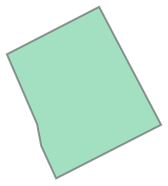

In [32]:
[res_group] = [grp for grp, bands in res_groups.items() if band in bands]
out_shape = MAX_DIMS[res_group]

print('Resolution Group: ',res_group)
print('Output Shape', out_shape)

farm_shapes = train_df.geometry.to_list()

# Get an boolean mask array with all farms in it
masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes, invert=True)

farm_id = 368
farm_shape = train_df.geometry.iloc[farm_id]

print('Farm shape:')
display(farm_shape)

In [33]:
%%time
data = get_farm_data(masked_raster, raster, farm_shape, out_shape)

CPU times: user 368 ms, sys: 175 ms, total: 543 ms
Wall time: 97.5 ms


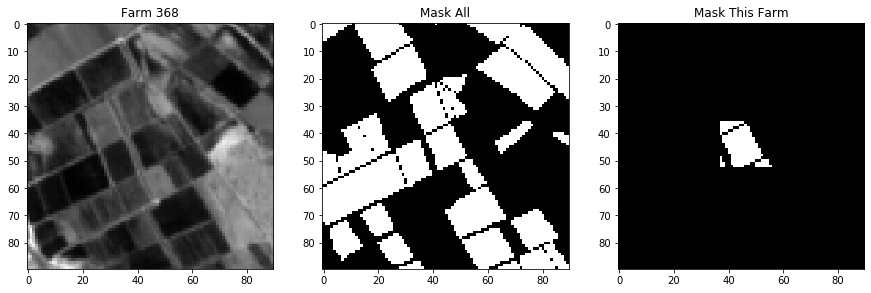

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

ax=axes[0]
ax.imshow(data[0], cmap='gray')
ax.set_title('Farm {}'.format(farm_id))

ax=axes[1]
ax.imshow(data[-2], cmap='gray')
ax.set_title('Mask All')

ax=axes[2]
ax.imshow(data[-1], cmap='gray')
ax.set_title('Mask This Farm');

In [35]:
from tqdm import tqdm


def get_farms_data(farm_shapes, raster, out_shape):
    """
    
    """
    
     # Get an boolean mask array with all farms in it
    masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes.geometry.to_list(), invert=True)
    
    all_data = {}
    
    for id, shape in tqdm(farm_shapes.iteritems()):
        farm_data = get_farm_data(masked_raster, raster, shape, out_shape)
        
        if type(farm_data) == np.ndarray:
            all_data[id] = farm_data
        
    return all_data
        

## Get farm data for all farms

In [36]:
farm_shapes = train_df.set_index("Field_Id").geometry

with rasterio.open(fp) as raster:
    farms_data = get_farms_data(farm_shapes, raster, out_shape)

2494it [03:33, 11.67it/s]


### Show image and mask data of 3 random farms

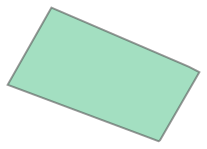

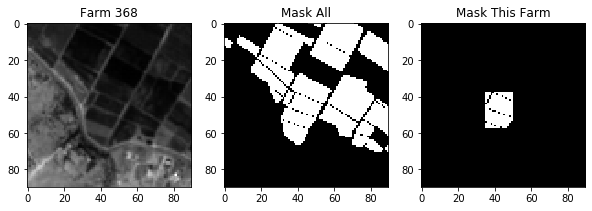

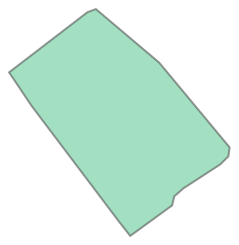

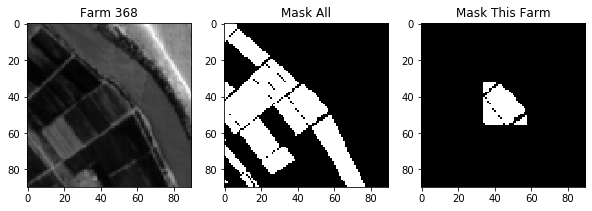

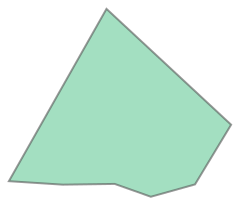

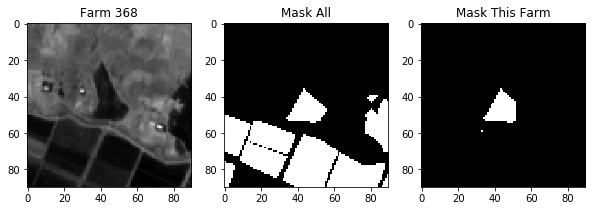

In [37]:
choices = np.random.choice(list(farms_data.keys()), (3,))

for i, random_farm_id in enumerate(choices):
    
    fig, axes = plt.subplots(1, 3, figsize=(10,15))
    
    display(farm_shapes[random_farm_id])
    
    farm_data = farms_data[random_farm_id]
    
    ax=axes[0]
    ax.imshow(farm_data[0], cmap='gray')
    ax.set_title('Farm {}'.format(farm_id))

    ax=axes[1]
    ax.imshow(farm_data[1], cmap='gray')
    ax.set_title('Mask All')

    ax=axes[2]
    ax.imshow(farm_data[2], cmap='gray')
    ax.set_title('Mask This Farm')
    
    plt.show()

## Save data

In [40]:
for farm_id, data in tqdm(farms_data.items()):
    out_fp = os.path.join(out_dir, f'farm_{farm_id}.npy')
    np.save(out_fp, data)

100%|██████████| 2494/2494 [00:02<00:00, 905.16it/s]


## Turn into scripts

In [45]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob

import sys
sys.path.append('../')
from config import raw_data_dir, processed_data_dir

import rasterio
from rasterio.mask import raster_geometry_mask

from src.utils import read_shapefile

res_groups = {
    '60': ['B01', 'B09', 'B10'],
    '20': ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12'],
    '10': ['B02', 'B03', 'B04', 'B08', 'TCI']
}

# Dimensions to zero-pad images to
MAX_DIMS = {
    '10': (90, 90),
    '20': (50, 50),
    '60': (20, 20)
}

dates = ['2017-01-01','2017-02-10','2017-03-22','2017-06-20',
         '2017-07-15','2017-08-19','2017-01-31','2017-03-12',
         '2017-05-31','2017-07-10','2017-08-04']

bands = ['B01','B02','B03','B04','B05','B06','B07','B8A','B09','B10','B11','B12','TCI']


# Input images
images_dir ='../data/interim/images-merged/'

img_dir = img_dir = os.path.join(images_dir, date)

out_dir = os.path.join(processed_data_dir, 'data_v1', date)

if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    

def get_mask_window(shape, raster, max_dims=None):
    
    # Get the boolean mask and window of shape
    try:
        bool_mask, transform, bb_window = raster_geometry_mask(raster, [shape], crop=True)
    except ValueError:
        return None
    
    if max_dims is  None:
        return bb_window
    else:
        # Turn mask into int array with 1 at farm pixels
        int_mask = np.bitwise_not(bool_mask).astype(int)

        # Get the shape of the bounding box window
        bb_shape = (bb_window.height, bb_window.width)


        # Get number of pixels to add to x and y dims
        pad_x = int(np.ceil((max_dims[1]-bb_shape[1])/2))
        pad_y = int(np.ceil((max_dims[0]-bb_shape[0])/2))

        # Get a window with padding around it and the desired shape in the center
        # Depending on the shape, this window can be a different size than max_dims
        window_ = rasterio.mask.geometry_window(raster, 
                                                      [shape], 
                                                      pad_x=pad_x, 
                                                      pad_y=pad_y, 
                                                      pixel_precision=2 # I found this fixes some rounding errors
                                                     )

        # To fix sizing issues, create a new window that starts at the same top left anchor, but of a fixed width and height
        window = rasterio.windows.Window(col_off=window_.col_off, row_off=window_.row_off, width=max_dims[1], height=max_dims[0])
    
        return window
    
    
def get_farm_data(masked_raster, raster, farm_shape, out_shape):
    
    bands = raster.count
    
    # The window defining where on the raster this shape is found
    mask_window = get_mask_window(farm_shape, raster, max_dims=None)
    
    if mask_window is None:
        return 0.
    
    # The same window, but padded to the desired dims
    mask_window_padded = get_mask_window(farm_shape, raster, max_dims=out_shape)

    # Crop out the image data around the shape 
    win_img = raster.read(window=mask_window_padded)[0]

    # Crop out the boolean mask of all farms in the window around the farm of interest
    win_mask_other = masked_raster[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                                   mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]
    
    temp = np.copy(masked_raster)

    temp[:mask_window.row_off,:] = False
    temp[mask_window.row_off+mask_window.width:,:]=False
    temp[:,:mask_window.col_off] = False
    temp[:,mask_window.col_off+mask_window.height:]=False

    win_mask_farm = temp[mask_window_padded.row_off:mask_window_padded.row_off+out_shape[0], 
                         mask_window_padded.col_off:mask_window_padded.col_off+out_shape[1]]

    del temp

    
    data = np.zeros((bands+2, *out_shape))
    data[:bands] = win_img
    data[-2] = win_mask_other
    data[-1] = win_mask_farm
    
    return data   

def get_farms_data(farm_shapes, raster, out_shape):
    """
    
    """
    
     # Get an boolean mask array with all farms in it
    masked_raster, _, _  = rasterio.mask.raster_geometry_mask(raster, farm_shapes.geometry.to_list(), invert=True)
    
    all_data = {}
    
    for id, shape in tqdm(farm_shapes.iteritems()):
        farm_data = get_farm_data(masked_raster, raster, shape, out_shape)
        
        if type(farm_data) == np.ndarray:
            all_data[id] = farm_data
        
    return all_data

In [46]:
def extract_masks(shp_df, date):
    
    print('-'*50,date,'-'*50)
    
    shp_df = read_shapefile(dataset)
    
    farm_shapes = shp_df.geometry
    
    for band in bands:
        
        print('\tBand: ',band)
        fp = os.path.join(images_dir, date, f'{band}.jp2')
        
        [res_group] = [grp for grp, bands in res_groups.items() if band in bands]
        out_shape = MAX_DIMS[res_group]
        
        with rasterio.open(fp) as raster:
            farms_data = get_farms_data(farm_shapes, raster, out_shape)
            
        save_data(farms_data, band)


def save_data(farms_data, band):
    
    print('Saving...',end='')
    for farm_id, data in farms_data.items():
        out_fp = os.path.join(date_dir, f'farm_{farm_id}_{band}.npy')
        np.save(out_fp, data)
    print('done')



for dataset in ['train','test']:
    
    print('-'*50,dataset,'-'*50)
    
    # create dir
    dataset_dir = os.path.join(out_dir, dataset)
    
    if not os.path.isdir(dataset_dir):
        os.makedirs(dataset_dir)
    
    shp_df = read_shapefile(dataset)

    for date in dates:
        # create dir
        date_dir = os.path.join(dataset_dir, date)
        
        if not os.path.isdir(date_dir):
            os.makedirs(date_dir)
            
        extract_masks(shp_df, date)
        
        
    
    

-------------------------------------------------- train --------------------------------------------------
-------------------------------------------------- 2017-01-01 --------------------------------------------------


0it [00:00, ?it/s]

	Band:  B01


2494it [00:06, 388.82it/s]


Saving...done
	Band:  B02


2494it [03:31, 11.80it/s]


Saving...done
	Band:  B03


2494it [03:33, 14.27it/s]


Saving...done
	Band:  B04


866it [01:17, 11.16it/s]

KeyboardInterrupt: 

866it [01:30, 11.16it/s]